In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs
from schmeud._schmeud import statics
from schmeud import ml

from dataclasses import dataclass
from collections import defaultdict

from numba import njit

In [2]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [3]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [4]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [11]:
# 2D version of excess entropy

@njit
def excess_entropy(r, g, dr):
    prelim = (g*np.log(g)-g+1)*r*dr
    prelim[np.isnan(prelim)] = 0
    return -np.pi*np.sum(prelim)

@njit
def local_excess_entropy(r, sfs, dr):
    vol = 4*np.pi*(r[-1]**3)
    inv_shell = 1/(4*np.pi*(r**2)*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        sf = sfs[i,::2] + sfs[i,1::2]
        inv_n = 1/np.sum(sf)
        g = sf*inv_shell*inv_n*vol
        out[i] = excess_entropy(r, g, dr)
    return out


@njit
def local_excess_entropy_binary(r, sfs, dr):
    vol = 4*np.pi*(r[-1]**2)
    inv_shell = 1/(2*np.pi*r*dr)
    out = np.zeros(len(sfs))
    for i in range(len(sfs)):
        na = np.sum(sfs[i,::2])
        nb = np.sum(sfs[i,1::2])
        n = na + nb
        inv_na = 1/na
        inv_nb = 1/nb
        g_a = sfs[i,::2]*inv_shell*inv_na*vol
        g_b = sfs[i,1::2]*inv_shell*inv_nb*vol
        out[i] = na/n*excess_entropy(r, g_a, dr) + nb/n*excess_entropy(r, g_b, dr)
    return out

# @njit
# def process_local_excess_entropy(r, sfs):
#     dr = r[1]-r[0]
#     out = np.zeros(len(sfs))
#     for i in range(len(sfs)):
#         entr = local_excess_entropy_binary(r, sfs[i], dr)
#         for j in range(len(r)):
#             out[i,j] = entr[j]
#     return out

In [78]:
# output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    
    experiments = sorted(glob.glob(job.fn("experiments/*/*/traj_period-*.gsd")))

    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"experiments/max-shear-{max_shear}/temp-{temp}/excess-entropy_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0:
            continue

        # if job.isfile(df_path):
        #     # dataset = pd.read_parquet(job.fn(df_path))
        #     # output[sp].append(dataset)
        #     continue

        traj = gsd.hoomd.open(exper)

        print(max_shear, period, temp)

        entr = []
        frames = []
        types = []
        for i in range(15, 20):
            frame = -1 + i*40
            frames.append(frame)

            snap = traj[frame] # initial state
            query_indices = np.arange(snap.particles.N)

            sfs = ml.compute_structure_functions_snap(snap, query_indices)

            r = np.linspace(0.4, 3.0, 27)
            dr = r[1] - r[0]
            entr.append(local_excess_entropy_binary(r, sfs, dr))
            types.append(snap.particles.typeid)
            # break
        dataset = pd.DataFrame({"frame": frames, "id": types, "entr": entr})
        dataset = dataset.explode(["id", "entr"]).reset_index(drop=True)
        dataset.to_parquet(job.fn(df_path))
#         output[sp].append(dataset)

# # save to pickle
# with open(project.fn("resultsmean_entr/t1-counts_period-1000.pkl"), "wb") as f:
#     pickle.dump(output, f)

634e14bc75836df75158fb15f379d8bb
0.01 1000.0 0.0496
0.01 1000.0 0.0992
0.01 1000.0 0.1488
0.01 1000.0 0.1984
0.02 1000.0 0.0496
0.02 1000.0 0.0992
0.02 1000.0 0.1488
0.02 1000.0 0.1984
0.03 1000.0 0.0496
0.03 1000.0 0.0992
0.03 1000.0 0.1488
0.03 1000.0 0.1984
0.05 1000.0 0.0496
0.05 1000.0 0.0992
0.05 1000.0 0.1488
0.05 1000.0 0.1984
0.08 1000.0 0.0496
0.08 1000.0 0.0992
0.08 1000.0 0.1488
0.08 1000.0 0.1984
0.12 1000.0 0.0496
0.12 1000.0 0.0992
0.12 1000.0 0.1488
0.12 1000.0 0.1984
7ec2f6aca035e69077eab24383a21cb6
0.01 1000.0 0.0496
0.01 1000.0 0.0992
0.01 1000.0 0.1488
0.01 1000.0 0.1984
0.02 1000.0 0.0496
0.02 1000.0 0.0992
0.02 1000.0 0.1488
0.02 1000.0 0.1984
0.03 1000.0 0.0496
0.03 1000.0 0.0992
0.03 1000.0 0.1488
0.03 1000.0 0.1984
0.05 1000.0 0.0496
0.05 1000.0 0.0992
0.05 1000.0 0.1488
0.05 1000.0 0.1984
0.08 1000.0 0.0496
0.08 1000.0 0.0992
0.08 1000.0 0.1488
0.08 1000.0 0.1984
0.12 1000.0 0.0496
0.12 1000.0 0.0992
0.12 1000.0 0.1488
0.12 1000.0 0.1984
cfa1e4c0007fd65d020f80

In [89]:
# plot mean excess entropy for each frame and system 
output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    
    experiments = sorted(glob.glob(job.fn("experiments/*/*/traj_period-*.gsd")))

    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"experiments/max-shear-{max_shear}/temp-{temp}/excess-entropy_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)

        if float(period) != 1000.0:
            continue

        if not job.isfile(df_path):
            # dataset = pd.read_parquet(job.fn(df_path))
            # output[sp].append(dataset)
            continue

        # print(sp)
        df = pd.read_parquet(job.fn(df_path))
        frames = []
        entrs = []
        for frame, gdf in df.groupby("frame"):
            frames.append(frame)
            entrs.append(np.mean(gdf["entr"]))
        dataset = pd.DataFrame({"frame": frames, "mean_entropy": entrs})
        output[sp].append(dataset)

    
# save to pickle
with open(project.fn("results/excess-entropy_period-1000_shear-0.01.pkl"), "wb") as f:
    pickle.dump(output, f)
        

634e14bc75836df75158fb15f379d8bb
7ec2f6aca035e69077eab24383a21cb6
cfa1e4c0007fd65d020f809715a6f0b4
ecce68c50e28a33684826f28780bf6e9
1d0fe2ba44a6f635f5504dcbcee0ebc9
1083a2a09eec2c6cf215ebc7a9706cac
09d3dccc56f1fa9330b57901cd232ab7
6976a7c10ada4159010403f8027f3ea5
9158e73b2e4c9fd1a565e1e5d1bc3af5
c6d7afd0de62bfa16d05da47815227eb
bf92a185d043ce3ef666e05e427c7e76
a8f2c249ed85533b56b0729b7ab96d18


In [100]:
def plot_mean_entropy(shear, ax=None, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    else:
        fig = ax.figure
    
    cmap = cm.inferno
    norm = colors.Normalize(vmin=0, vmax=.3)

    for k, v in output.items():
        if k.max_shear != shear:
            continue
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = "-"

        mean_entr = np.mean([v_i["mean_entropy"].values for v_i in v], axis=0)
        # frames = v[0]["frame"].values
        ax.plot(np.arange(15, 20), mean_entr, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}")

    ax.set_ylabel("Mean excess entropy", size="large")
    ax.set_xlabel("Cycle", size="large")
    if legend:
        ax.legend(title="Temp Prep")
    fig.suptitle(f"Mean local entropy; {shear} shear, 1000 period")

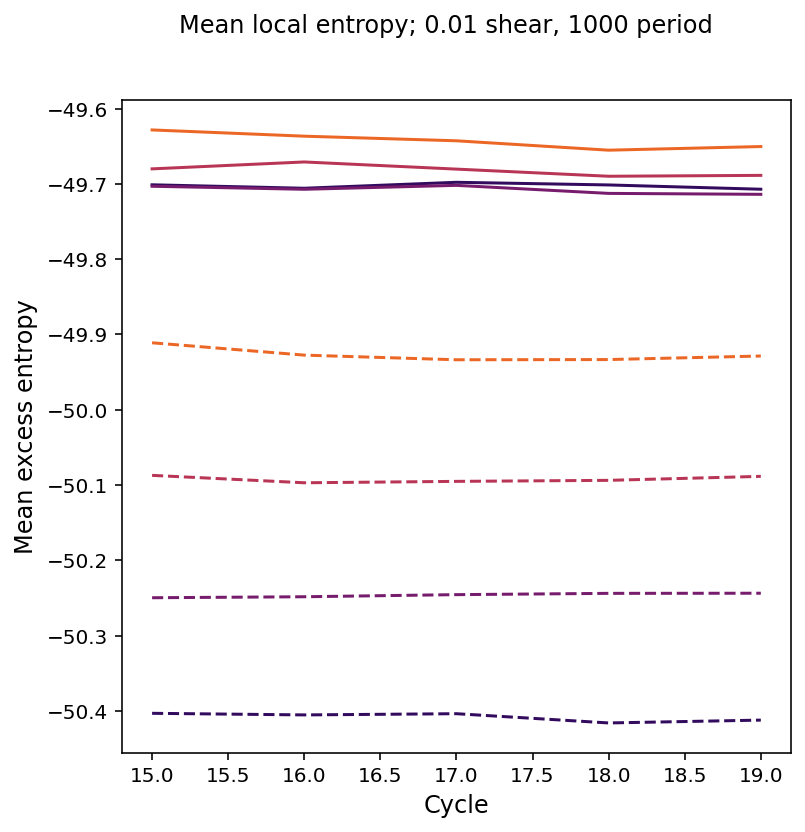

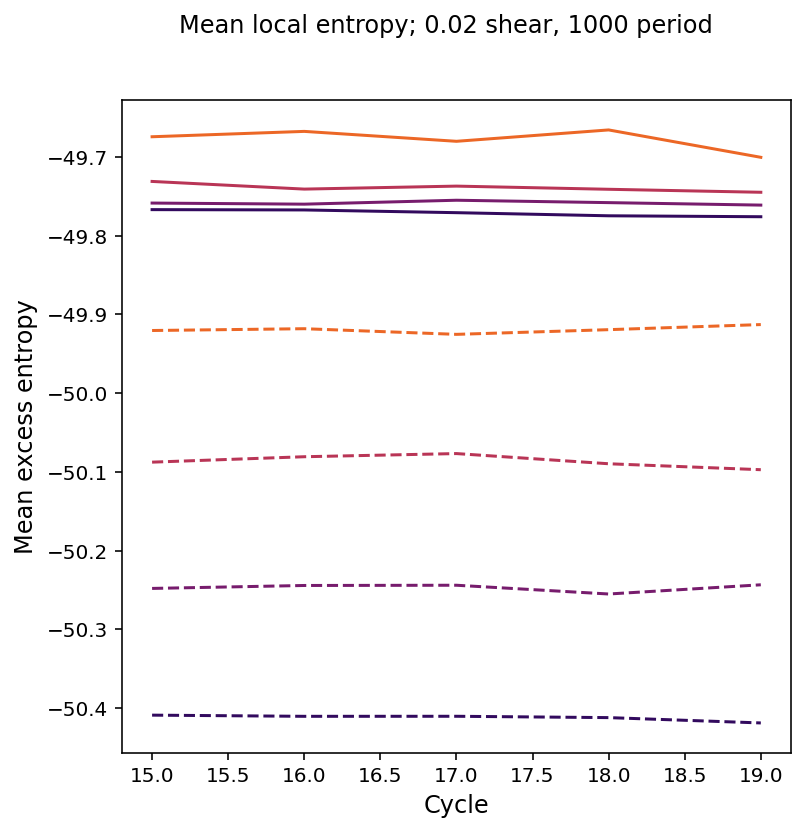

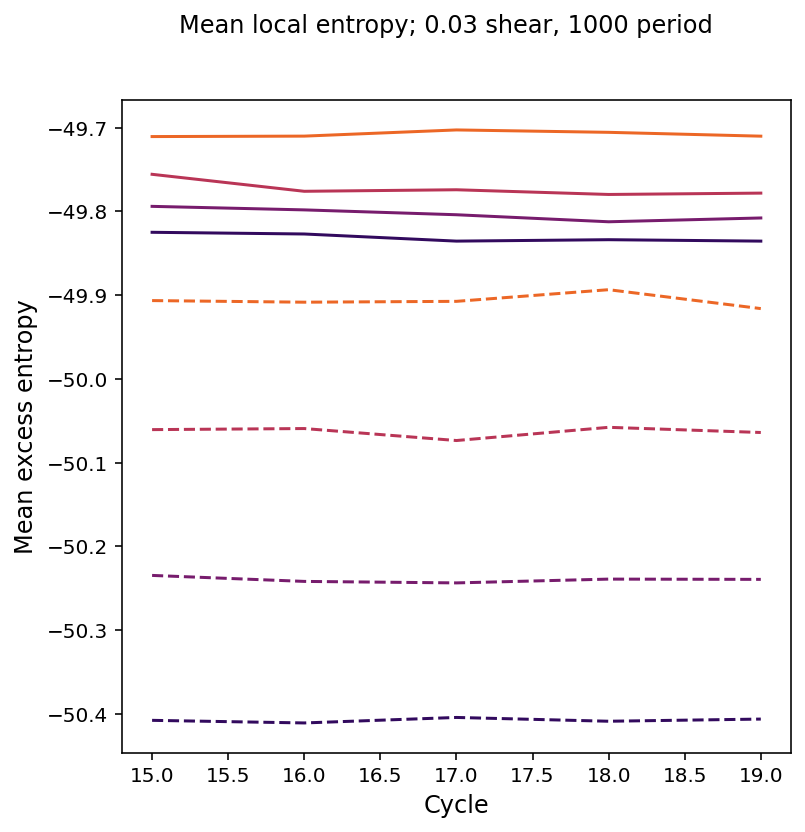

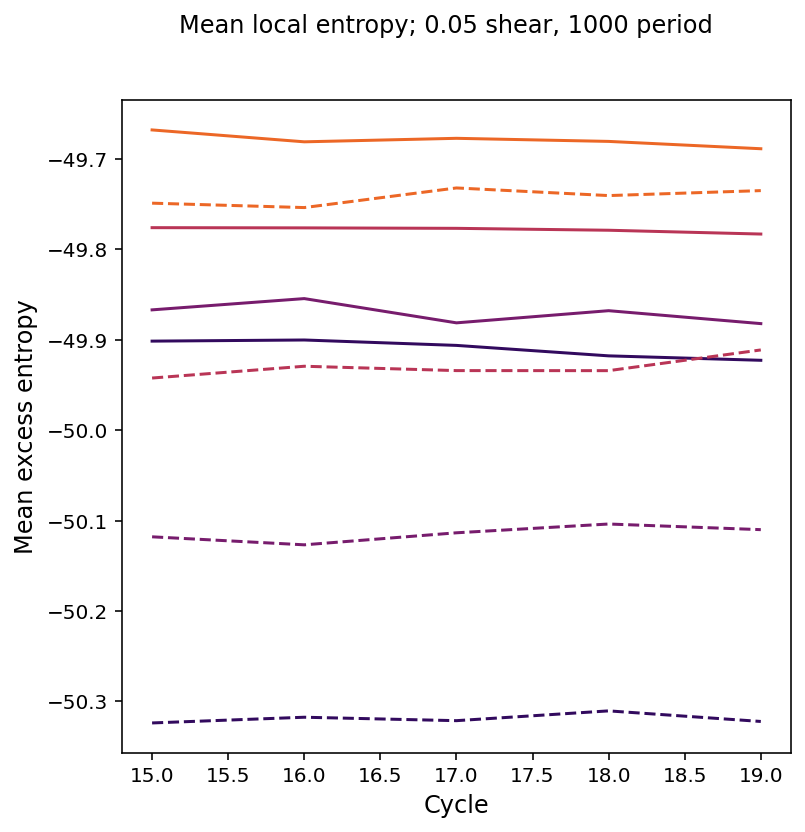

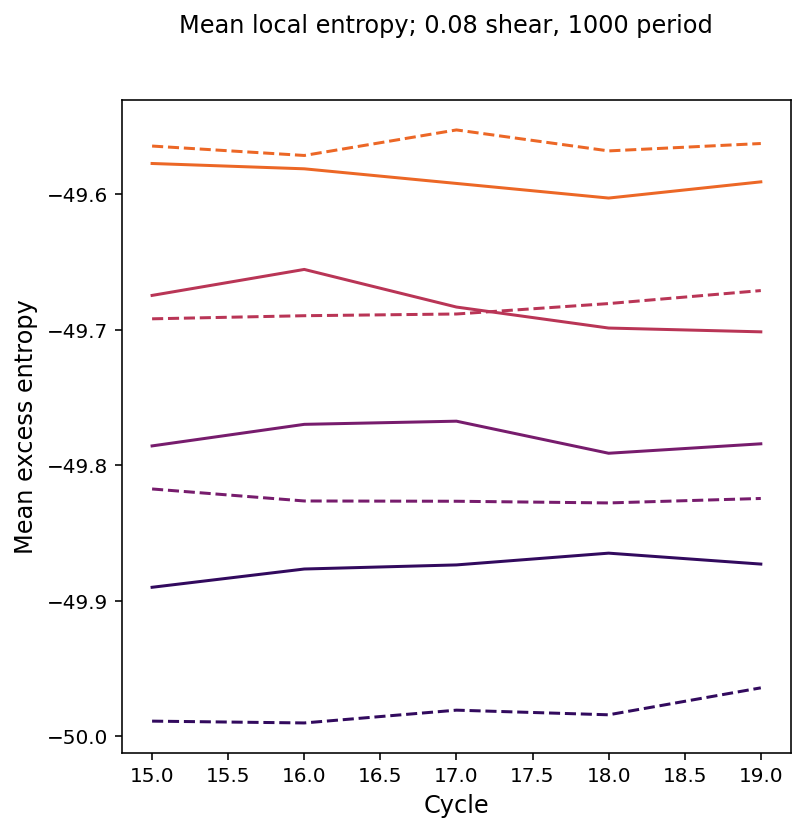

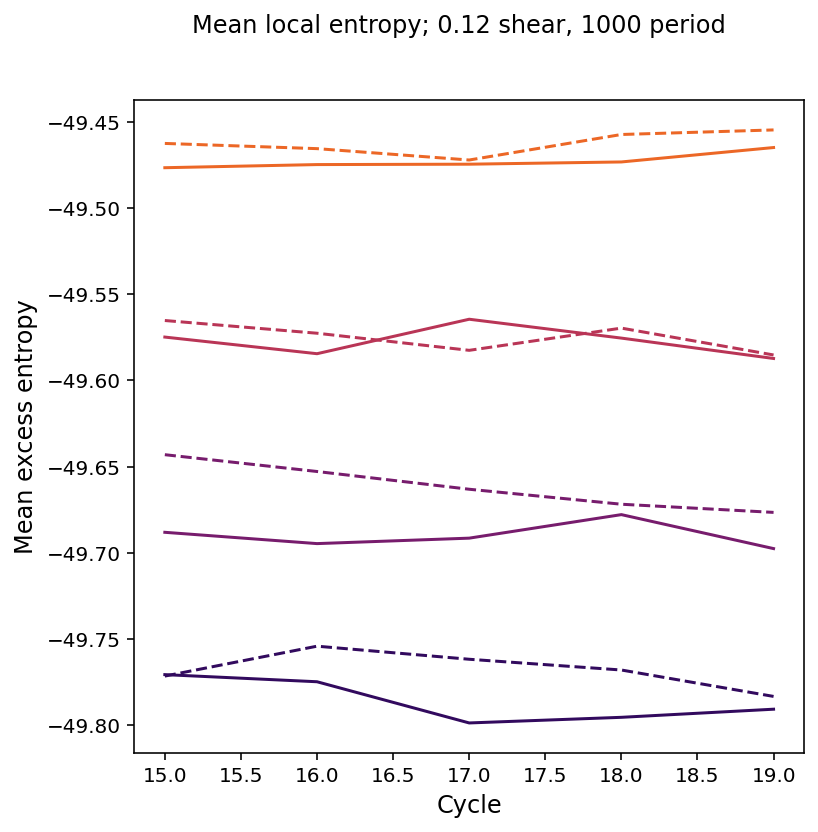

In [101]:
for shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plot_mean_entropy(shear, legend=False)

In [98]:
# plot mean excess entropy for each frame and system 
output2 = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    
    experiments = sorted(glob.glob(job.fn("experiments/*/*/traj_period-*.gsd")))

    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        df_path = f"experiments/max-shear-{max_shear}/temp-{temp}/excess-entropy_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)

        if float(period) != 1000.0:
            continue

        if not job.isfile(df_path):
            # dataset = pd.read_parquet(job.fn(df_path))
            # output[sp].append(dataset)
            continue

        # print(sp)
        df = pd.read_parquet(job.fn(df_path))
        frames = []
        entrs = []
        for frame, gdf in df.groupby("frame"):
            frames.append(frame)
            entrs.append(gdf["entr"].to_numpy())
        dataset = pd.DataFrame({"frame": frames, "entropy": entrs})
        output2[sp].append(dataset)

    
# save to pickle
with open(project.fn("results/excess-entropy-distr_period-1000_shear-0.01.pkl"), "wb") as f:
    pickle.dump(output2, f)
        

634e14bc75836df75158fb15f379d8bb
Statepoint(max_shear=0.01, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.1488, prep='HTL')
Statepoint(max_shear=0.01, period=1000.0, temp=0.1984, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.1488, prep='HTL')
Statepoint(max_shear=0.02, period=1000.0, temp=0.1984, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.1488, prep='HTL')
Statepoint(max_shear=0.03, period=1000.0, temp=0.1984, prep='HTL')
Statepoint(max_shear=0.05, period=1000.0, temp=0.0496, prep='HTL')
Statepoint(max_shear=0.05, period=1000.0, temp=0.0992, prep='HTL')
Statepoint(max_shear=0.05, pe

In [96]:
def plot_entropy_distr(shear, ax=None, legend=True):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    else:
        fig = ax.figure
    cmap = cm.inferno
    norm = colors.Normalize(vmin=0, vmax=.3)

    for k, v in output2.items():
        if k.max_shear != shear:
            continue
        # print(k)
        c = cmap(norm(k.temp))
        if k.prep == "ESL":
            ls = "--"
        else:
            ls = "-"


        entr = []
        for v_i in v:
            for v_ii in v_i["entropy"]:
                entr.append(v_ii)
        entr = np.concatenate(entr)
        # frames = v[0]["frame"].values
        bins = 50
        y, x = np.histogram(entr, bins=bins, density=True)
        x = (x[1:] + x[:-1]) / 2
        plt.plot(x, y, color=c, linestyle=ls, label=f"{k.temp:.3f} {k.prep}", alpha=0.5)

    ax.set_ylabel("Density", size="large")
    ax.set_xlabel("Local excess entropy", size="large")
    if legend:
        ax.legend(title="Temp Prep")
    fig.suptitle(f"Local excess entropy distribution; {shear} shear, 1000 period")
    plt.yscale('log')

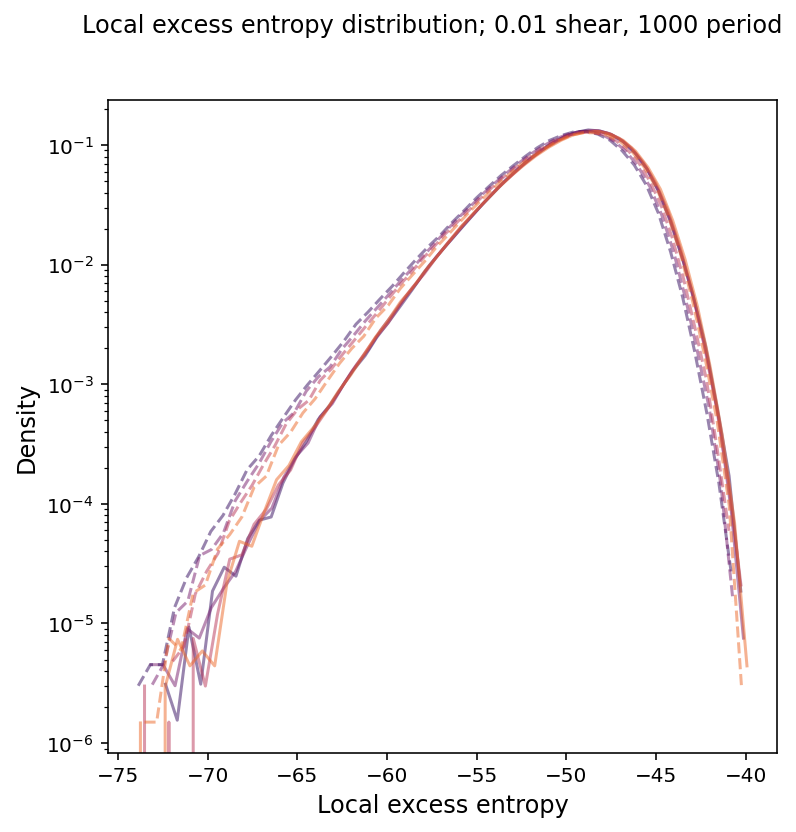

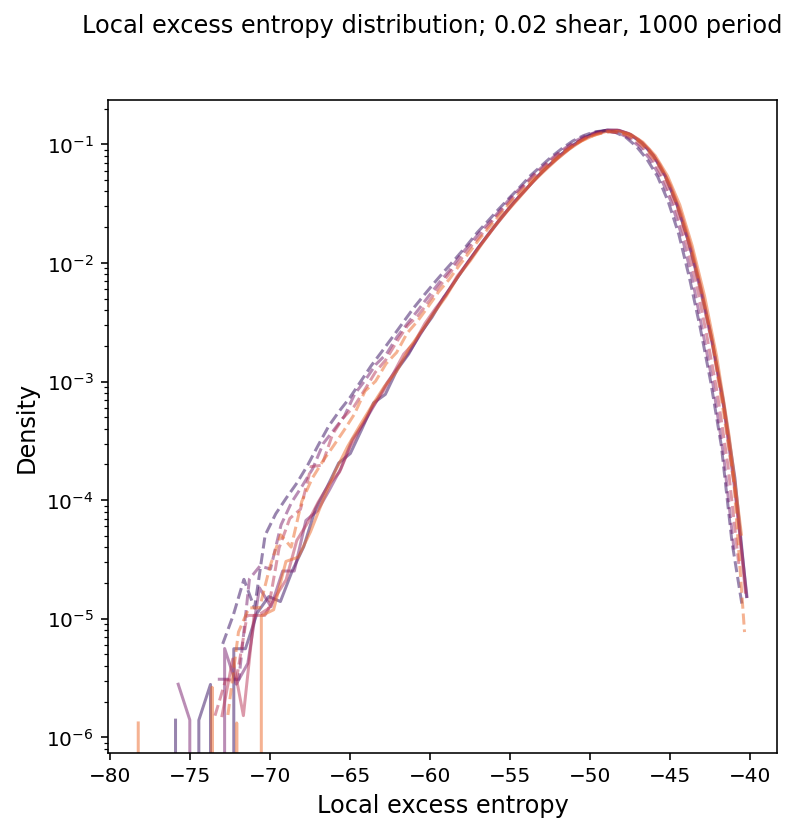

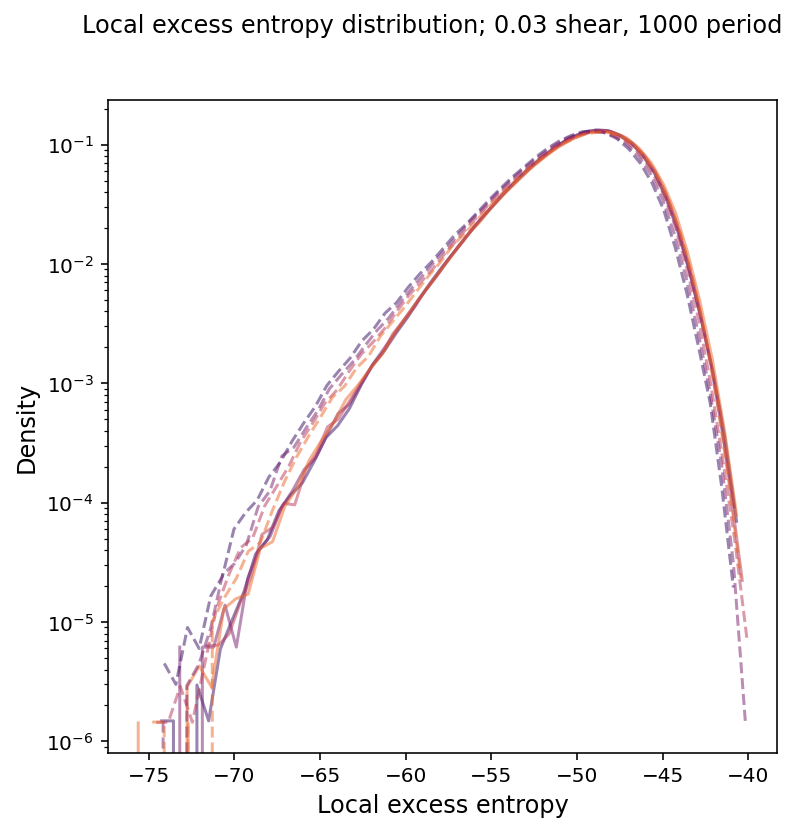

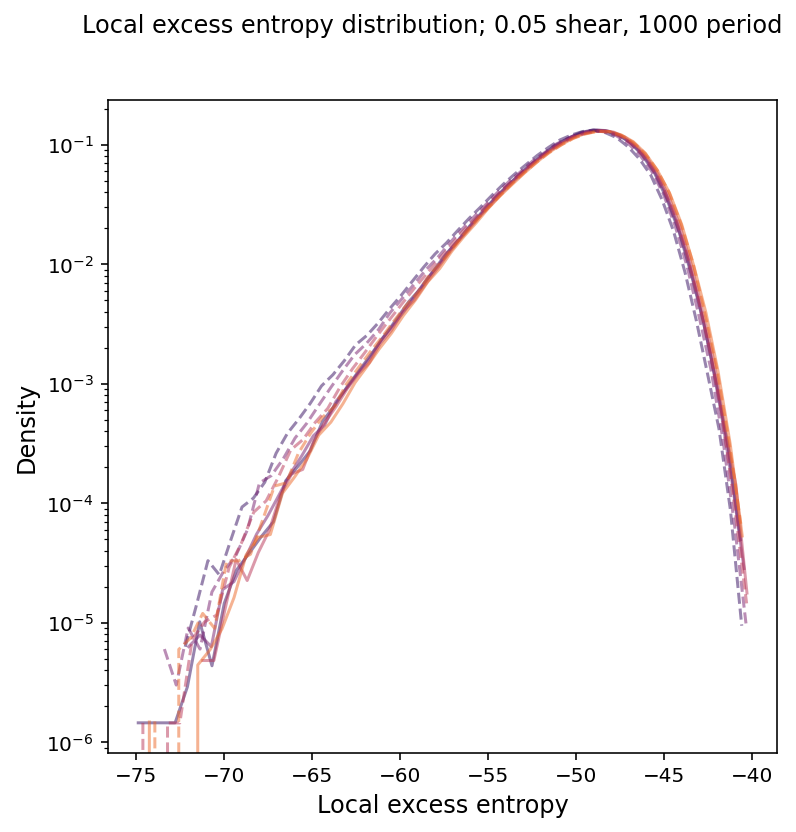

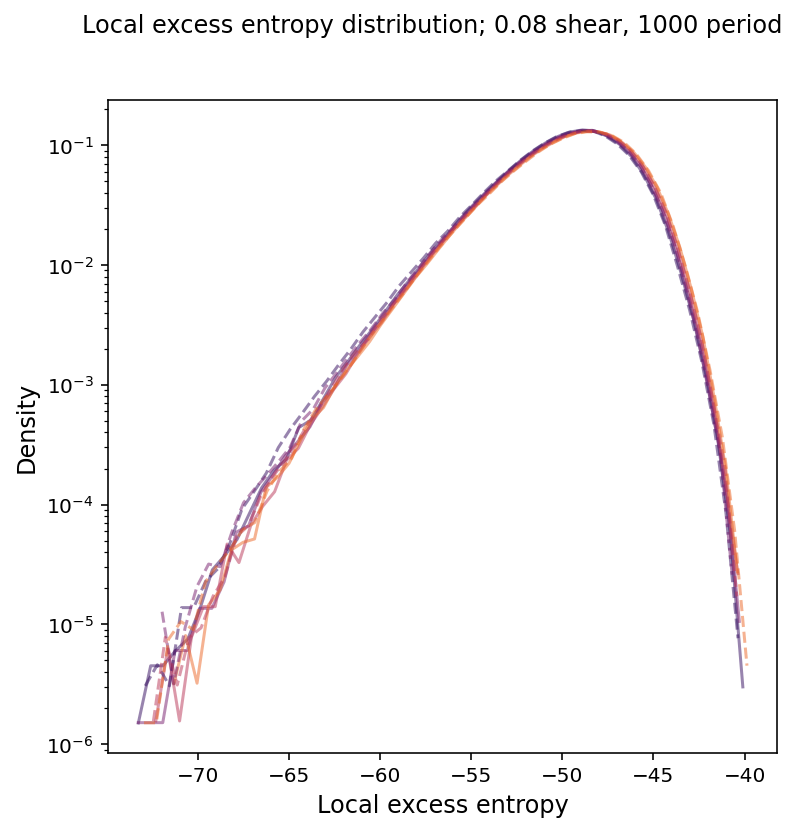

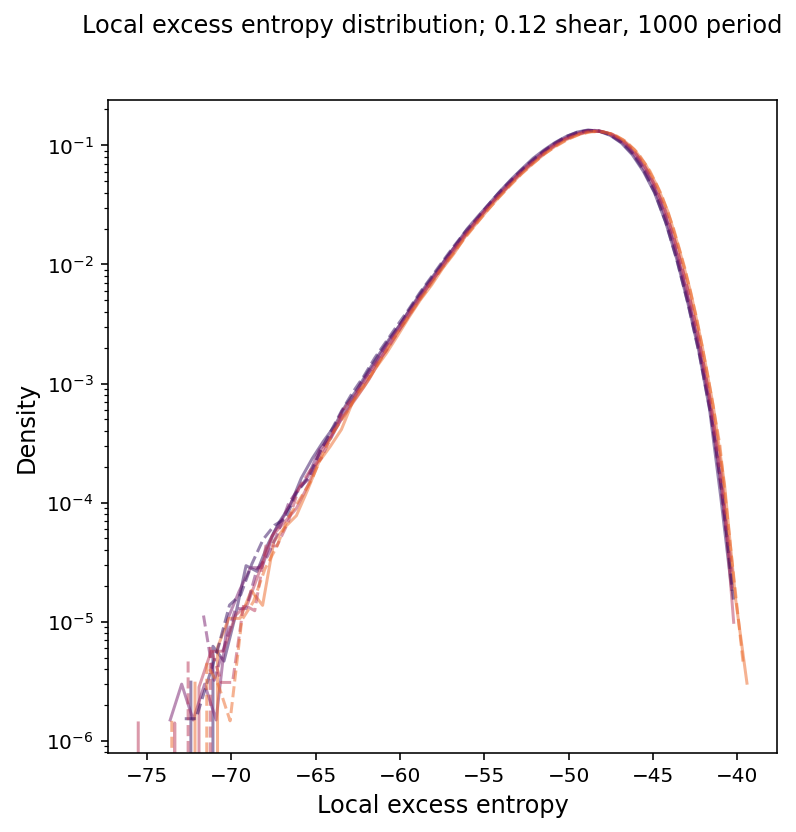

In [99]:
for shear in [0.01, 0.02, 0.03, 0.05, 0.08, 0.12]:
    plot_entropy_distr(shear, legend=False)
    